DRAG - Imperfect Qubits 💡💔
=======================
In a perfect world, example 2 would have been enough to control a simple one qubit system. Unfortunately, we don't live in a perfect world 😟

One of the problems with the previous example is that it doesn't take into account the actual physical quantum properties of our qubit system. We use a **transmon** as our qubit implementation, which is a non-linear circuit based on the *Josephson junction* to create *artificial atoms*. A transmon, unlike an actual qubit, is not a two-level system! It is a system with many levels and we use the first two levels as our qubit. The reason we can use only the first two levels is that the levels are *non-linear* meaning the energy difference between neighboring levels is different for all levels (unlike the quantum harmonic oscillator, which has infinite energy levels each distance $\hbar \omega$ from its neighbor), this way we can isolate the first two levels from the other and use it as a qubit.

In this example we'll treat the fact that there are more than 2 levels. We are going to create a quantum object with three levels instead of two and add the penalty on the third "forbidden" by adding the option `drag=True` the optimization function call

### 👉 imports

In [1]:
import sys
sys.path.insert(1, r'..')
import grape  # This is mine :)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import qutip as qt  # qutip is used only to easily define basic quantum operators and turn them into numpy ndarrays
import scipy.ndimage as ndi

plt.style.use("ggplot")

### 👉 Ladder operators
Setting up qubit ladder operators, $\hat{q}$ and $\hat{q}^\dagger$. This time, since there are more than two levels, we are going to define a variable `trans_lvls` which is the number of levels in our transmon

In [2]:
trans_lvls = 3

q = qt.destroy(trans_lvls)
qd = q.dag()
# Turn qutip objects to numpy
q = np.array(q)
qd = np.array(qd)

### 👉 Hamiltonians ⚡
The Hamiltonian this time is going to be a little different. The second-ti-third level frequency is different from the frequency of the first two levels, the levels are *an-harmonic*, this is why we need to add an an-harmonicity term $\frac{\alpha}{2}(\hat{q}^\dagger)^2 \hat{q}^2$.
$$\hat{H}_0 = \omega\hat{q}^\dagger \hat{q} - \frac{\alpha}{2}(\hat{q}^\dagger)^2 \hat{q}^2$$
The Hamiltonian of the interaction between the microwave pulses and the transmon doesn't change
$$\hat{H}_I = (\hat{q} + \hat{q}^\dagger)$$
$$\hat{H}_Q = (\hat{q} - \hat{q}^\dagger)\cdot i$$
And the total Hamiltonian is the sum
$$\hat{H} = \hat{H}_0 + \epsilon_I(t) \hat{H}_I + \epsilon_Q(t) \hat{H}_Q$$
We seek to find optimal $\epsilon_I (t)$ and $\epsilon_Q (t)$

In [3]:
# Constants
omega = 1
alpha = 0.35  # Typical size of the an-harmonicity is 3~5% of the frequency omega

In [4]:
H_0 = omega*qd@q - (alpha/2)*qd@qd@q@q
H_I = qd + q
H_Q = (qd - q)*1j

### 👉 Time variables
**T** is the total time, **Ns** is the number of time steps and **times** is array of all time steps

In [5]:
T     = 100
Ns    = 500
times = np.linspace(0.0, T, Ns)

### 👉 Initial and target states
Setting initial and target states. $|\psi_{initial}>\ =\ |0>$ and $|\psi_{target}>\ =\ |1>$

In [6]:
psi_initial = np.array(qt.basis(trans_lvls, 0))
psi_target  = np.array(qt.basis(trans_lvls, 1))

### 👉 Initial pulses guess
We treat the the drive amplitudes $\epsilon_I(t)$ and $\epsilon_Q(t)$ as step-wise constant function, with step size of $\frac{T}{Ns}$ and a total of $Ns$ steps. This is why, in code, each drive amplitude is a numpy ndarray of length Ns. To find optimal drive amplitudes we need to give the program an initial guess, we'll guesss a random pulse

In [7]:
def gaussian(size, sigma, amp, graph=False):
    gaussian_window = np.zeros(size)
    for x in range(size):
        gaussian_window[x] = amp * np.exp(-(x - size / 2 ** 2) / sigma ** 2)
        if graph:
            plt.figure()
            plt.plot(times[0:size], gaussian_window)
    return gaussian_window

In [8]:
gaussian_window = gaussian(int(Ns/10), Ns/50, 1)

rand_amp_Q = 1/3000
rand_amp_I = 1/3000

conv_I = (ndi.convolve((np.random.random(Ns) - 0.5) *
                       2 * rand_amp_I, gaussian_window, mode='wrap'))
conv_Q = (ndi.convolve((np.random.random(Ns) - 0.5) *
                       2 * rand_amp_Q, gaussian_window, mode='wrap'))

e_I = conv_I
e_Q = conv_Q

### 👉 Constraints
We'll now define the strength of the constraints (the lagrange multipliers, $\lambda$'s). In this example we will only have soft constraint (instead of hard constraints such as cut-off amplitude and frequency). We'll only define constraints on the amplitude and the bandwidht, $\lambda_{amp}$ and $\lambda_{band}$.

In [9]:
lambda_amp = 0
lambda_band = 0.1

We need to put the multiple drive hamiltonians into one variable and also for the multiple drive amplitudes.
We set a variable, *drive_hamiltonians*, which is a list of all the drive hamiltonians, and a variable, *pulses*, which is a list of the drive amplitudes. Notice that the two lists need to be the same length and that the $i^{th}$ drive hamiltonian in the list correspond to the $i^{th}$ drive amplitude in the list

In [10]:
drive_hamiltonians = [H_I, H_Q]
pulses    = np.array([e_I, e_Q])

### 👉 Creating GRAPE object
We now create the *GrapePulse* object, which contains all the data on the pulse and can be used for the optimization

In [11]:
grape_pulse = grape.GrapePulse(psi_initial, psi_target, T, Ns, H_0, drive_hamiltonians,
                               pulses, constraints=True, lambda_amp_lin=lambda_amp, lambda_band_lin=lambda_band, drag=True)

## 👉 Optimizing 🛠
We now run the GRAPE optimization, we can choose to graph the probabilites over the duration of the pulse before and after the optimization

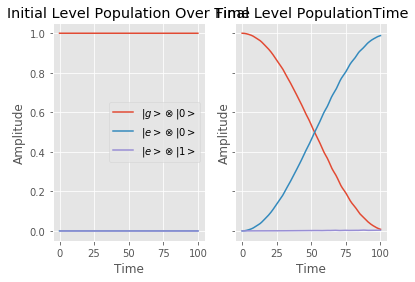

In [12]:
results = grape_pulse.optimize(graph_prob=True)

We get back a dictionary with all the results we need: optimized drive amplitudes, final fidelity, the Hamiltonians (which are allready known if you wrote this script, but usefull if you want to save it to a file), the Hilbert space dimensions and some comments you can add. The dictionary has the form:
* **"pulses"**: *ndarray* of shape (number of drive amplitudes$\ \times\ $number of time steps)
* **"fidelity"**: *float* of the final fidelity
* **"Hamiltonians"**:
    * **"constant"**: *ndarray* matrix of the constant hamiltonian
    * **"drives"**: *list of ndarray* matrices of the drive hamiltonians
* **"dimensions"**: *ndarray* of list of original hilbert space dimensions
* **"comments"**: comments you can add (again, only useful when you save as a file and want to understand what these results mean

### 👉 Graphing the results 📈

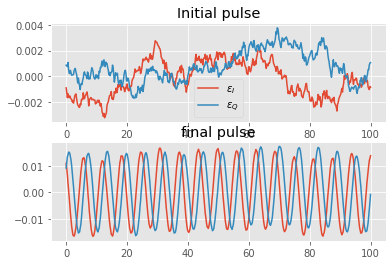

In [13]:
pulses = results["pulses"]

fig, axes = plt.subplots(2)
# --- Initial ---
axes[0].set_title("Initial pulse")
axes[0].plot(times, e_I)
axes[0].plot(times, e_Q)
axes[0].legend([r'$\epsilon_I$', r'$\epsilon_Q$'])
# --- Final ---
axes[1].set_title("final pulse")
axes[1].plot(times,  pulses[0])
axes[1].plot(times,  pulses[1])

Now we got smooth results as expected

### Checking final fidelity
One last thing we need to check is that the final fidelity is actually close to $1$, let's check that now

In [14]:
print("A fidelity of", results["fidelity"], "was achieved by the optimization")

A fidelity of 0.9010986408732523 was achieved by the optimization
